# 1 - 词向量运算

因为词嵌入的训练是非常耗资源的，所以大部分人都是选择加载训练好的词嵌入数据。在本博客中，我们将学习到：
1. 如何加载训练好了的词向量
2. 使用余弦相似性计算相似度
3. 使用词嵌入来解决“男人与女人相比就像国王与__相比”之类的词语类比问题
4. 修改词嵌入以减少性别偏见等

In [2]:
import numpy as np
import w2v_utils

接下来就是加载词向量了，这里我们使用50维的向量来表示单词：

In [3]:
words, word_to_vec_map = w2v_utils.read_glove_vecs('data/glove.6B.50d.txt')

我们加载了以下数据：
- words：单词的集合
- word_to_vec_map：字典类型，单词到GloVe向量的映射

In [4]:
# python 3.x
print(word_to_vec_map['hello'])

[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


因为独热向量不能很好地表示词与词之间的相似性，所以使用了GlovVel向量，它保存了每个单词更多、更有用的信息，我们现在可以看到如何比较两个词的相似性

## 1.1 - 余弦相似度

![](images/a1.png)
![](images/cosine_sim.png)
<center>图1-1：两个向量之间的夹角余弦值用来衡量它们的相似程度</center>

接下来我们要实现一个计算两个词的相似度的函数`cosine_similarity()`

提醒：u的范数是这样定义的：$||u||_2 = \sqrt{\sum_{i=1}^n u_i^2}$

In [5]:
def cosine_similarity(u, v):
    """
    u与v的余弦相似度反映了u与v的相似程度
    
    参数：
        u -- 维度为(n,)的词向量
        v -- 维度为(n,)的词向量
        
    返回：
        cosine_similarity -- 由上面公式定义的u和v之间的余弦相似度。
    """
    distance = 0
    
    # 计算u与v的内积
    dot = np.dot(u, v)
    
    #计算u的L2范数
    norm_u = np.sqrt(np.sum(np.power(u, 2)))
    
    #计算v的L2范数
    norm_v = np.sqrt(np.sum(np.power(v, 2)))
    
    # 根据公式1计算余弦相似度
    cosine_similarity = np.divide(dot, norm_u * norm_v)
    
    return cosine_similarity

In [6]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.27439246261379424
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174202


当然你也可以随意修改其他词汇，然后看看它们只的相似性

## 1.2 - 词类类比

在这里，我们将学习解决“A与B相比就类似于C与____ 相比一样”之类的问题，打个比方，“男人与女人相比就像国王与 女皇 相比”。实际上我们需要找到一个词d,然后$e_a,e_b,e_c,e_d$满足以下关系：$e_b-e_a ≈ e_d-e_c$，当然$e_b-e_a$与$e_d-e_c$是使用余弦相似性来判断的

In [7]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    解决“A与B相比就类似于C与____相比一样”之类的问题
    
    参数：
        word_a -- 一个字符串类型的词
        word_b -- 一个字符串类型的词
        word_c -- 一个字符串类型的词
        word_to_vec_map -- 字典类型，单词到GloVe向量的映射
        
    返回：
        best_word -- 满足(v_b - v_a) 最接近 (v_best_word - v_c) 的词
    """
    
    # 把单词转换为小写
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    # 获取对应单词的词向量
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    
    # 获取全部的单词
    words = word_to_vec_map.keys()
    
    # 将max_cosine_sim初始化为一个比较大的负数
    max_cosine_sim = -100
    best_word = None
    
    # 遍历整个数据集
    for word in words:
        # 要避免匹配到输入的数据
        if word in [word_a, word_b, word_c]:
            continue
        # 计算余弦相似度
        cosine_sim = cosine_similarity((e_b - e_a), (word_to_vec_map[word] - e_c))
        
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = word
            
    return best_word

In [8]:
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} <====> {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

italy -> italian <====> spain -> spanish
india -> delhi <====> japan -> tokyo
man -> woman <====> boy -> girl
small -> smaller <====> large -> larger


可以随意地去更改上面的词汇，看看能否拿到自己期望的输出，你也可以试试能不能让程序出一点小错呢？比如：small -> smaller <===> big -> ? ,自己试试呗~

In [9]:
triads_to_try = [('small', 'smaller', 'big')]
for triad in triads_to_try:
    print ('{} -> {} <====> {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

small -> smaller <====> big -> competitors


现在词类类比已经完成了，需要记住的是余弦相似度是比较词向量相似度的一种好方法，尽管使用L2距离（欧式距离）来比较也是可以的

## 1.3 - 去除词向量中的偏见（选学）

在这一部分，我们将研究反映在词嵌入中的性别偏差，并试着去去除这一些偏差，除了学习这个内容外，这一节还可以磨炼你对单词向量的直觉，这部分包含有线性代数，不是很难，如果你没有学习过线性代数，那么你可以跳过这一节，你也可以继续深入下去

我们首先来看一下包含在词嵌入中的性别偏差，我们首先计算一下$g = e_{woman}-e_{man}$，其中$e_{woman}$是单词"woman"对应的词向量，$e_{man}$是单词"man"对应的词向量，得到的结果g粗略的包含了性别这一概念，但是如果你计算$g_1=e_{mother}-e_{father}$与$g_2=e_{girl}-e_{boy}$的平均值，可能会更准确一点，但是在这里，$e_{woman}-e_{man}$就已经足够了

In [10]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


现在，我们不考虑不同单词与g的余弦相似度，考虑相似度的正值与余弦值的负值之间的关系

In [11]:
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

john -0.23163356145973724
marie 0.315597935396073
sophie 0.31868789859418784
ronaldo -0.3124479685032943
priya 0.17632041839009402
rahul -0.16915471039231722
danielle 0.24393299216283892
reza -0.07930429672199552
katy 0.2831068659572615
yasmin 0.23313857767928758


正如我们所看见的，女性的名字与g的与余弦相似度为正，而男性为负，这也不出乎人的意料，我们来看看其他词

In [12]:
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

lipstick 0.2769191625638266
guns -0.1888485567898898
science -0.060829065409296994
arts 0.008189312385880328
literature 0.06472504433459927
warrior -0.20920164641125288
doctor 0.11895289410935041
tree -0.07089399175478091
receptionist 0.33077941750593737
technology -0.13193732447554296
fashion 0.03563894625772699
teacher 0.17920923431825664
engineer -0.08039280494524072
pilot 0.0010764498991916787
computer -0.10330358873850498
singer 0.1850051813649629


发现了吗？比如“computer”就接近于“man”，“literature ”接近于“woman”，但是这些都是不对的一些观念，那么我们该如何减少这些偏差呢？

对于一些特殊的词汇而言，比如“男演员（actor）”与“女演员（actress）”或者“祖母（grandmother）”与“祖父（grandfather）”之间应该是具有性别差异的，但是其他的词汇比如“接待员（receptionist）”与“技术（technology ）”是不应该有性别差异的，当我们处理这些词汇的时候应该区别对待

### 1.3.1 - 消除与性别无关的词汇的偏差

![](images/a2.png)
![](images/neutral.png)
<center>图1-2：单词"recptionist"在消除性别偏差前后的示意图</center>

现在我们要实现`neutralize()`函数来消除包含在词汇向量里面的性别偏差，给定一个输入：词嵌入（embedding）e，那么我们可以使用下面的公式计算$e^{debiased}$

![](images/a3.png)

In [13]:
def neutralize(word, g, word_to_vec_map):
    """
    通过将“word”投影到与偏置轴正交的空间上，消除了“word”的偏差。
    该函数确保“word”在性别的子空间中的值为0
    
    参数：
        word -- 待消除偏差的字符串
        g -- 维度为(50,)，对应于偏置轴（如性别）
        word_to_vec_map -- 字典类型，单词到GloVe向量的映射
        
    返回：
        e_debiased -- 消除了偏差的向量。
    """
    
    # 根据word选择对应的词向量
    e = word_to_vec_map[word]
    
    # 根据公式2计算e_biascomponent
    e_biascomponent = np.divide(np.dot(e, g), np.square(np.linalg.norm(g))) * g
    
    # 根据公式3计算e_debiased
    e_debiased = e - e_biascomponent
    
    return e_debiased

In [14]:
e = "receptionist"
print("去偏差前{0}与g的余弦相似度为：{1}".format(e, cosine_similarity(word_to_vec_map["receptionist"], g)))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("去偏差后{0}与g的余弦相似度为：{1}".format(e, cosine_similarity(e_debiased, g)))

去偏差前receptionist与g的余弦相似度为：0.33077941750593737
去偏差后receptionist与g的余弦相似度为：1.1682064664487028e-17


请注意：你的第二个结果可能与我不一样，但基本上是接近于0的$(10^{-17})$

### 1.3.2 - 性别词的均衡算法

接下来我们来看看在关于有特定性别词组中，如何将它们进行均衡，比如“男演员”与“女演员”中，与“保姆”一词更接近的是“女演员”，我们可以消去“保姆”的性别偏差，但是这并不能保证“保姆”一词与“男演员”与“女演员”之间的距离相等，我们要学的均衡算法将解决这个问题

均衡算法背后的关键思想是确保一对特定的单词与49维的$g_⊥$距离相等
![](images/equalize10.png)
线性代数的推导过程要复杂很多（细节见Bolukbasi et al., 2016），但是关键方程如下：
![](images/a4.png)

In [15]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    通过遵循上图中所描述的均衡方法来消除性别偏差。
    
    参数：
        pair -- 要消除性别偏差的词组，比如 ("actress", "actor") 
        bias_axis -- 维度为(50,)，对应于偏置轴（如性别）
        word_to_vec_map -- 字典类型，单词到GloVe向量的映射
    
    返回：
        e_1 -- 第一个词的词向量
        e_2 -- 第二个词的词向量
    """
    # 第1步：获取词向量
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]
    
    # 第2步：计算w1与w2的均值
    mu = (e_w1 + e_w2) / 2.0
    
    # 第3步：计算mu在偏置轴与正交轴上的投影
    mu_B = np.divide(np.dot(mu, bias_axis), np.square(np.linalg.norm(bias_axis))) * bias_axis
    mu_orth = mu - mu_B
    
    # 第4步：使用公式7、8计算e_w1B 与 e_w2B
    e_w1B = np.divide(np.dot(e_w1, bias_axis), np.square(np.linalg.norm(bias_axis))) * bias_axis
    e_w2B = np.divide(np.dot(e_w2, bias_axis), np.square(np.linalg.norm(bias_axis))) * bias_axis
    
    # 第5步：根据公式9、10调整e_w1B 与 e_w2B的偏置部分
    corrected_e_w1B = np.sqrt(np.abs(1-np.square(np.linalg.norm(mu_orth)))) * np.divide(e_w1B-mu_B, np.abs(e_w1 - mu_orth - mu_B))
    corrected_e_w2B = np.sqrt(np.abs(1-np.square(np.linalg.norm(mu_orth)))) * np.divide(e_w2B-mu_B, np.abs(e_w2 - mu_orth - mu_B))
    
    # 第6步： 使e1和e2等于它们修正后的投影之和，从而消除偏差
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1, e2

In [16]:
print("==========均衡校正前==========")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("\n==========均衡校正后==========")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

==========均衡校正前==========
cosine_similarity(word_to_vec_map["man"], gender) =  -0.1171109576533683
cosine_similarity(word_to_vec_map["woman"], gender) =  0.3566661884627037

==========均衡校正后==========
cosine_similarity(e1, gender) =  -0.7165727525843935
cosine_similarity(e2, gender) =  0.7396596474928908


![](images/a5.png)

# 2 - Emoji表情生成器

在这里，我们要学习使用词向量来构建一个表情生成器

你有没有想过让你的文字也有更丰富表达能力呢？比如写下“Congratulations on the promotion! Lets get coffee and talk. Love you!”，那么你的表情生成器就会自动生成“Congratulations on the promotion! ? Lets get coffee and talk. ☕️ Love you! ❤️”

另一方面，如果你对这些表情不感冒，而你的朋友给你发了一大堆的带表情的文字，那么你也可以使用表情生成器来怼回去

我们要构建一个模型，输入的是文字（比如“Let’s go see the baseball game tonight!”），输出的是表情（⚾️）。在众多的Emoji表情中，比如“❤️”代表的是“心”而不是“爱”，但是如果你使用词向量，那么你会发现即使你的训练集只明确地将几个单词与特定的表情符号相关联，你的模型也了能够将测试集中的单词归纳、总结到同一个表情符号，甚至有些单词没有出现在你的训练集中也可以

在这里，我们将开始构建一个使用词向量的基准模型（Emojifier-V1），然后我们会构建一个更复杂的包含了LSTM的模型（Emojifier-V2）

请注意：你可能需要运行`pip install emoji`命令来获取emoji包

In [41]:
import numpy as np
import emo_utils
import emoji
import matplotlib.pyplot as plt
import importlib
importlib.reload(emo_utils)

%matplotlib inline

## 2.1 - 基准模型：Emojifier - V1

### 2.1.1 数据集

我们来构建一个简单的分类器，首先是数据集（X，Y）：
- X：包含了127个字符串类型的短句
- Y：包含了对应短句的标签（0 - 4）
![](images/dataset_kiank.png)
<center>图2-1：EMOJISET - 5类分类问题，这里给出了几个例子</center>

现在我们来加载数据集，训练集：127，测试集：56

In [36]:
X_train, Y_train = emo_utils.read_csv('data/train_emoji.csv')
X_test, Y_test = emo_utils.read_csv('data/test.csv')

maxLen = len(max(X_train, key=len).split())

你可以随意更改index的值来看看训练集里面到底有什么东西，使用jupyter notebook的用户需要注意的是，由于字体原因，你打印出来的心有可能是黑色的，但是没有任何问题

In [42]:
index  = 3
print(X_train[index], emo_utils.label_to_emoji(Y_train[index]))

Miss you so much ❤️


### 2.1.2 - Emojifier-V1的结构

在这里，我们要实现一个叫“Emojifier-V1”的基准模型
![](images/emo_model.png)
<center>图2-2：基准模型（Emojifier-V1）</center>

模型的输入是一段文字（比如“l lov you”），输出的是维度为(1,5)的向量，最后在argmax层找寻最大可能性的输出

现在我们将我们的标签Y YY转换成softmax分类器所需要的格式，即从(m,1)转换为独热编码(m,5)，每一行都是经过编码后的样本，其中Y_oh指的是“Y-one-hot”

In [43]:
Y_oh_train = emo_utils.convert_to_one_hot(Y_train, C=5)
Y_oh_test = emo_utils.convert_to_one_hot(Y_test, C=5)

当然，你也可以改变index的值来看看独热编码

In [44]:
index = 0 
print("{0}对应的独热编码是{1}".format(Y_train[index], Y_oh_train[index]))

3对应的独热编码是[0. 0. 0. 1. 0.]


数据集准备好了，现在我们就来实现这个模型

### 2.1.3 - 实现Emojifier-V1

正如图2-2所示，第一步就是把输入的句子转换为词向量，然后获取均值，我们依然使用50维的词嵌入，现在我们加载词嵌入：

In [45]:
word_to_index, index_to_word, word_to_vec_map = emo_utils.read_glove_vecs('data/glove.6B.50d.txt')

我们加载了：
- word_to_index：字典类型的词汇（400,001个）与索引的映射（有效范围：0-400,000）
- index_to_word：字典类型的索引与词汇之间的映射
- word_to_vec_map：字典类型的词汇与对应GloVe向量的映射

In [46]:
word = "cucumber"
index = 113317
print("单词{0}对应的索引是：{1}".format(word, word_to_index[word]))
print("索引{0}对应的单词是：{1}".format(index, index_to_word[index]))

单词cucumber对应的索引是：113317
索引113317对应的单词是：cucumber


我们将实现`sentence_to_avg()`函数，我们可以将之分为以下两个步骤：
1. 把每个句子转换为小写，然后分割为列表。我们可以使用X.lower() 与 X.split()
2. 对于句子中的每一个单词，转换为GloVe向量，然后对它们取平均

In [47]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    将句子转换为单词列表，提取其GloVe向量，然后将其平均。
    
    参数：
        sentence -- 字符串类型，从X中获取的样本。
        word_to_vec_map -- 字典类型，单词映射到50维的向量的字典
        
    返回：
        avg -- 对句子的均值编码，维度为(50,)
    """
    
    # 第一步：分割句子，转换为列表。
    words = sentence.lower().split()
    
    # 初始化均值词向量
    avg = np.zeros(50,)
    
    # 第二步：对词向量取平均。
    for w in words:
        avg += word_to_vec_map[w]
    avg = np.divide(avg, len(words))
    
    return avg

In [48]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


我们现在应该实现所有的模型结构了，在使用sentence_to_avg()之后，进行前向传播，计算损失，再进行反向传播，最后再更新参数

我们根据图2-2实现model()函数，Y o n YonYon是已经经过独热编码后的Y YY，那么前向传播以及计算损失的公式如下：
![](images/a6.png)
当然你可能有更高效率的向量化实现方式，但是这里我们只使用for循环

In [49]:
def model(X, Y, word_to_vec_map, learning_rate=0.01, num_iterations=400):
    """
    在numpy中训练词向量模型。
    
    参数：
        X -- 输入的字符串类型的数据，维度为(m, 1)。
        Y -- 对应的标签，0-7的数组，维度为(m, 1)。
        word_to_vec_map -- 字典类型的单词到50维词向量的映射。
        learning_rate -- 学习率.
        num_iterations -- 迭代次数。
        
    返回：
        pred -- 预测的向量，维度为(m, 1)。
        W -- 权重参数，维度为(n_y, n_h)。
        b -- 偏置参数，维度为(n_y,)
    """
    np.random.seed(1)
    
    # 定义训练数量
    m = Y.shape[0]
    n_y = 5
    n_h = 50
    
    # 使用Xavier初始化参数
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # 将Y转换成独热编码
    Y_oh = emo_utils.convert_to_one_hot(Y, C=n_y)
    
    # 优化循环
    for t in range(num_iterations):
        for i in range(m):
            # 获取第i个训练样本的均值
            avg = sentence_to_avg(X[i], word_to_vec_map)
            
            # 前向传播
            z = np.dot(W, avg) + b
            a = emo_utils.softmax(z)
            
            # 计算第i个训练的损失
            cost = -np.sum(Y_oh[i]*np.log(a))
            
            # 计算梯度
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz
            
            # 更新参数
            W = W - learning_rate * dW
            b = b - learning_rate * db
        if t % 100 == 0:
            print("第{t}轮，损失为{cost}".format(t=t,cost=cost))
            pred = emo_utils.predict(X, Y, W, b, word_to_vec_map)
            
    return pred, W, b

In [50]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)


In [51]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)

第0轮，损失为1.9520498812810072
Accuracy: 0.3484848484848485
第100轮，损失为0.07971818726014807
Accuracy: 0.9318181818181818
第200轮，损失为0.04456369243681402
Accuracy: 0.9545454545454546
第300轮，损失为0.03432267378786059
Accuracy: 0.9696969696969697


### 2.1.4 - 验证集

In [52]:
print("=====训练集====")
pred_train = emo_utils.predict(X_train, Y_train, W, b, word_to_vec_map)
print("=====测试集====")
pred_test = emo_utils.predict(X_test, Y_test, W, b, word_to_vec_map)

=====训练集====
Accuracy: 0.9772727272727273
=====测试集====
Accuracy: 0.8571428571428571


假设有5个类别，随机猜测的准确率在20%左右，但是仅仅经过127个样本的训练，就有很好的表现。在训练集中，算法看到了“I love you”的句子，其标签为“❤️”，在训练集中没有“adore”这个词汇，如果我们写“I adore you”会发生什么？

In [53]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "you are not happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = emo_utils.predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
emo_utils.print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol :smile:
lets play with a ball ⚾
food is ready 🍴
you are not happy ❤️


因为词嵌入的原因，“adore”与“love”很相似，所以它可以正确表达出“❤️”，但是在“you are not happy”中却表达了“❤️”，其原因是我们这个算法使用均值，忽略了排序，所以不善于理解“not happy”这一类词汇

我们把矩阵打印出来应该会帮助你理解哪些类让模型学习起来比较困难，横轴为预测，竖轴为实际标签

 	 ❤️ 	 ⚾ 	 :smile: 	 :disappointed: 	 🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


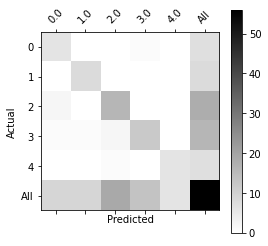

In [54]:
print(" \t {0} \t {1} \t {2} \t {3} \t {4}".format(emo_utils.label_to_emoji(0), emo_utils.label_to_emoji(1), \
                                                 emo_utils.label_to_emoji(2), emo_utils.label_to_emoji(3), \
                                                 emo_utils.label_to_emoji(4)))
import pandas as pd
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
emo_utils.plot_confusion_matrix(Y_test, pred_test)

完成了这一部分之后，你需要记住的是：
1. 即使你只有128个训练样本，你也可以得到很好地表情符号模型，因为词向量是训练好了的，它会给你一个较好的概括能力
2. Emojifier-V1是有缺陷的，比如它不会把“This movie is not good and not enjoyable”划分为不好一类，因为它只是将所有单词的向量做了平均，没有关心过顺序

## 2.2 - Emojifier-V2：在Keras中使用LSTM模块

现在我们构建一个能够接受输入文字序列的模型，这个模型会考虑到文字的顺序。Emojifier-V2依然会使用已经训练好的词嵌入

In [55]:
import numpy as np
np.random.seed(0)
import keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.core import Embedding
from keras.preprocessing import sequence

np.random.seed(1)
from keras.initializers import glorot_uniform

### 2.2.1 - 模型预览

我们将实现下面这一个模型：
![](images/emojifier-v2.png)
<center>图 2-3: Emojifier-V2：一个两层的LSTM的序列分类器</center>

### 2.2.2 - Keras与mini-batching

在这个部分中，我们会使用mini-batches来训练Keras模型，但是大部分深度学习框架需要使用相同的长度的文字，这是因为如果你使用3个单词与4个单词的句子，那么转化为向量之后，计算步骤就有所不同（一个是需要3个LSTM，另一个需要4个LSTM），所以我们不可能对这些句子进行同时训练

那么通用的解决方案是使用填充。指定最长句子的长度，然后对其他句子进行填充到相同长度。比如：指定最大的句子的长度为20，我们可以对每个句子使用“0”来填充，直到句子长度为20，因此，句子“I love you”就可以表示为$(e_I,e_{love},e_{you},0,0,...,0)$在这个例子中，任何任何一个超过20个单词的句子将被截取，所以一个比较简单的方式就是找到最长句子，获取它的长度，然后指定它的长度为最长句子的长度

### 2.2.3 - 嵌入层（ The Embedding layer）

在keras里面，嵌入矩阵被表示为“layer”，并将正整数（对应单词的索引）映射到固定大小的Dense向量（词嵌入向量），它可以使用训练好的词嵌入来接着训练或者直接初始化。在这里，我们将学习如何在Keras中创建一个Embedding()层，然后使用Glove的50维向量来初始化。因为我们的数据集很小，所以我们不会更新词嵌入，而是会保留词嵌入的值

在`Embedding()`层中，输入一个整数矩阵（batch的大小，最大的输入长度），我们可以看看下图：
![](images/emb_kiank.png)
<center>图 2-4: Embedding 层</center>

这个例子展示了两个样本通过embedding层，两个样本都经过了`max_len=5`的填充处理，最终的维度就变成了`(2, max_len, 5)`，这是因为使用了50维的词嵌入。

  输入的最大的数（也就是说单词索引）不应该超过词汇表包含词汇的数量，这一层的输出的数组的维度为(batch size, max input length, dimension of word vectors)
  
  第一步就是把所有的要训练的句子转换成索引列表，然后对这些列表使用0填充，直到列表长度为最长句子的长度
  
  我们先来实现一个函数，输入的是X（字符串类型的句子的数组），再转化为对应的句子列表，输出的是能够让Embedding()函数接受的列表或矩阵（参见图2-4）

In [56]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    输入的是X（字符串类型的句子的数组），再转化为对应的句子列表，
    输出的是能够让Embedding()函数接受的列表或矩阵（参见图4）。
    
    参数：
        X -- 句子数组，维度为(m, 1)
        word_to_index -- 字典类型的单词到索引的映射
        max_len -- 最大句子的长度，数据集中所有的句子的长度都不会超过它。
        
    返回：
        X_indices -- 对应于X中的单词索引数组，维度为(m, max_len)
    """
    
    m = X.shape[0]  # 训练集数量
    # 使用0初始化X_indices
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        # 将第i个居住转化为小写并按单词分开。
        sentences_words = X[i].lower().split()
        
        # 初始化j为0
        j = 0
        
        # 遍历这个单词列表
        for w in sentences_words:
            # 将X_indices的第(i, j)号元素为对应的单词索引
            X_indices[i, j] = word_to_index[w]
            
            j += 1
            
    return X_indices

In [58]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


现在我们就在Keras中构建Embedding()层，我们使用的是已经训练好了的词向量，在构建之后，使用sentences_to_indices()生成的数据作为输入，Embedding()层将返回每个句子的词嵌入

我们现在就实现pretrained_embedding_layer()函数，它可以分为以下几个步骤：
1. 使用0来初始化嵌入矩阵
2. 使用word_to_vec_map来将词嵌入矩阵填充进嵌入矩阵
3. 在Keras中定义嵌入层，当调用Embedding()的时候需要让这一层的参数不能被训练，所以我们可以设置trainable=False
4. 将词嵌入的权值设置为词嵌入的值

In [59]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    创建Keras Embedding()层，加载已经训练好了的50维GloVe向量
    
    参数：
        word_to_vec_map -- 字典类型的单词与词嵌入的映射
        word_to_index -- 字典类型的单词到词汇表（400,001个单词）的索引的映射。
        
    返回：
        embedding_layer() -- 训练好了的Keras的实体层。
    """
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    
    # 初始化嵌入矩阵
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # 将嵌入矩阵的每行的“index”设置为词汇“index”的词向量表示
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    # 定义Keras的embbeding层
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    
    # 构建embedding层。
    embedding_layer.build((None,))
    
    # 将嵌入层的权重设置为嵌入矩阵。
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [60]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## 2.3 - 构建Emojifier-V2

现在我们开始构建Emojifier-V2模型。embedding层我们已经构建完成了，现在我们将它的输出输入到LSTM中
![](images/emojifier-v2.png)
<center>图 2-3: Emojifier-V2：一个两层的LSTM的序列分类器</center>

现在实现Emojifier_V2()函数，模型的输入是(m, max_len)，定义在了input_shape中，输出是(m, C=5)，你可能需要参考Input(shape = ..., dtype = '...'), LSTM(), Dropout(), Dense(), 与 Activation()

In [61]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    实现Emojify-V2模型的计算图
    
    参数：
        input_shape -- 输入的维度，通常是(max_len,)
        word_to_vec_map -- 字典类型的单词与词嵌入的映射。
        word_to_index -- 字典类型的单词到词汇表（400,001个单词）的索引的映射。
    
    返回：
        model -- Keras模型实体
    """
    # 定义sentence_indices为计算图的输入，维度为(input_shape,)，类型为dtype 'int32' 
    sentence_indices = Input(input_shape, dtype='int32')
    
    # 创建embedding层
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # 通过嵌入层传播sentence_indices，你会得到嵌入的结果
    embeddings = embedding_layer(sentence_indices)
    
    # 通过带有128维隐藏状态的LSTM层传播嵌入
    # 需要注意的是，返回的输出应该是一批序列。
    X = LSTM(128, return_sequences=True)(embeddings)
    # 使用dropout，概率为0.5
    X = Dropout(0.5)(X)
    # 通过另一个128维隐藏状态的LSTM层传播X
    # 注意，返回的输出应该是单个隐藏状态，而不是一组序列。
    X = LSTM(128, return_sequences=False)(X)
    # 使用dropout，概率为0.5
    X = Dropout(0.5)(X)
    # 通过softmax激活的Dense层传播X，得到一批5维向量。
    X = Dense(5)(X)
    # 添加softmax激活
    X = Activation('softmax')(X)
    
    # 创建模型实体
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

 因为数据集中所有句子都小于10个单词，所以我们选择max_len=10。在接下来的代码中，你应该可以看到有“20,223,927”个参数，其中“20,000,050”个参数没有被训练（这是因为它是词向量），剩下的是有“223,877”被训练了的。因为我们的单词表有400,001个单词，所以是400 , 001 ∗ 50 = 20 , 000 , 050 400,001*50=20,000,050400,001∗50=20,000,050个不可训练的参数

In [70]:
max_len = 10
model = Emojify_V2((max_len,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           91648     
                                                                 
 dropout_4 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 645 

与往常一样，在Keras中创建模型以后，我们需要编译并评估这个模型。我们可以使用categorical_crossentropy 损失, adam 优化器与 [‘accuracy’] 指标

In [71]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

现在我们开始训练模型，Emojifier-V2模型是以(m, max_len)为输入，(m, number of classes)为输出。我们需要将X_train转化为X_train_indices，Y_train转化为Y_train_oh

In [72]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = emo_utils.convert_to_one_hot(Y_train, C = 5)

我们需要使用X_train_indices 与 Y_train_oh来拟合模型，我们使用epochs = 50 与 batch_size = 32

In [73]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 3s 10ms/step - loss: 1.6054 - accuracy: 0.2727
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 1.5177 - accuracy: 0.3030
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.4887 - accuracy: 0.3636
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.4120 - accuracy: 0.4621
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 1.3374 - accuracy: 0.4773
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 1.1865 - accuracy: 0.5909
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 1.0705 - accuracy: 0.5682
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 0.9242 - accuracy: 0.6364
Epoch 9/50
5/5 [==============================] - 0s 9ms/step - loss: 0.8413 - accuracy: 0.7045
Epoch 10/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6875 - accuracy: 0.7955
Epoch 11/50
5/5 [===============

你的模型应在训练集上接近100%的准确率，每个人得到的结果应该是大同小异的。我们来看看在测试集的表现吧

In [74]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = emo_utils.convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)

print("Test accuracy = ", acc)

2/2 [==============================] - 2s 4ms/step - loss: 0.6157 - accuracy: 0.8214
Test accuracy =  0.8214285969734192


你的结果应该在80%到95%之间，我们来看看哪些被分类错误了吧

In [75]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('正确表情：'+ emo_utils.label_to_emoji(Y_test[i]) + '   预测结果： '+ X_test[i] + emo_utils.label_to_emoji(num).strip())

2/2 [==============================] - 0s 3ms/step
正确表情：:smile:   预测结果： he got a very nice raise	❤️
正确表情：:smile:   预测结果： she got me a nice present	❤️
正确表情：:disappointed:   预测结果： work is hard	:smile:
正确表情：:disappointed:   预测结果： This girl is messing with me	❤️
正确表情：🍴   预测结果： any suggestions for dinner	:smile:
正确表情：:smile:   预测结果： you brighten my day	❤️
正确表情：:disappointed:   预测结果： My life is so boring	❤️
正确表情：:disappointed:   预测结果： go away	⚾
正确表情：:disappointed:   预测结果： yesterday we lost again	⚾
正确表情：🍴   预测结果： I did not have breakfast :smile:


可以试试自己写一些话来预测，但是要确保你写的词汇包含在了Glove词嵌入内：

In [76]:
x_test = np.array(['you are so beautiful'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  emo_utils.label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 [==============================] - 0s 12ms/step
you are so beautiful ❤️


在以前的Emojiy-V1模型中它不会正确标记“不开心”，但是我们在Emojiy-V2中纠正了它。目前的Emojiy-V2模型在理解否定词上依旧是不大稳定的，这是因为训练集比较小，如果训练集比较大的话LSTM就会表现的更好